In [1]:
import time
import pymatching
import sinter
import stim
import numpy as np
from scipy.optimize import least_squares
from scipy.special import gammainc
import matplotlib.pyplot as plt

In [2]:
def count_logical_errors(circuit: stim.Circuit, Nshots: int) -> int:
  # Sample the circuit
  sampler = circuit.compile_detector_sampler()
  det_events, obs_flips = sampler.sample(Nshots, separate_observables=True)

  # Extract decoder configuration data from the circuit
  detector_error_model = circuit.detector_error_model(decompose_errors=True)

  # Run the decoder
  predictions = sinter.predict_observables(dem=detector_error_model,
                                           dets=det_events,
                                           decoder='pymatching')

  # Count the mistakes
  Nerr = 0
  for actual_flip, predicted_flip in zip(obs_flips, predictions):
    if not np.array_equal(actual_flip, predicted_flip):
      Nerr += 1
  return Nerr

In [6]:
# errfunc will be minimized via least-squares optimization
# p_in are order-of-magnitude initial guesses
fitfunc = lambda p, x: p[0] - p[1] / (1.0 + np.exp(p[2] * (x - p[3])))
#fitfunc = lambda p, x: p[0] + p[1] * np.tanh(p[2] * x - p[3])
errfunc = lambda p, x, y, err: (fitfunc(p, x) - y) / err
p_in = [0.5, 0.5, 10.0, 0.25]

# Define corresponding Jacobian matrix
def jac(p, x, y, err):
  J = np.empty((x.size, p.size))
  num = np.exp(p[2] * (x - p[3]))
  den = 1.0 + np.exp(p[2] * (x - p[3]))
  J[:, 0] = 1.0
  J[:, 1] = -1.0 / den
  J[:, 2] = p[1] * (x - p[3]) * num / den**2
  J[:, 3] = -1.0 * p[1] * p[2] * num / den**2
  for i in range(p.size):
    J[:, i] /= err
  return J

In [4]:
# Hard-coded constants
distance = [3, 5, 7]
num_d = len(distance)
colors = ['r', 'b', 'k']        # Fix color for each distance
marker = ['.', 'x', '+']        # Fix marker for each distance

error_probs = np.arange(0.005, 0.5, 0.005)
num_x = len(error_probs)
mid_x = np.median(error_probs)

Nsamples = 10
shots_per_sample = 1024

Doing d=3
[ 0.50099507  0.53739008 16.29309438  0.1671487 ]
chiSq/dof = 499/95 = 5.253 --> CL = 0
Runtime: 4.9 seconds

Doing d=5
[ 0.49700213  0.5047647  21.023566    0.21038566]
chiSq/dof = 913/95 = 9.61 --> CL = 0
Runtime: 7.5 seconds

Doing d=7
[ 0.49892765  0.50194636 23.31014974  0.24360909]
chiSq/dof = 1183/95 = 12.45 --> CL = 0
Runtime: 12.2 seconds



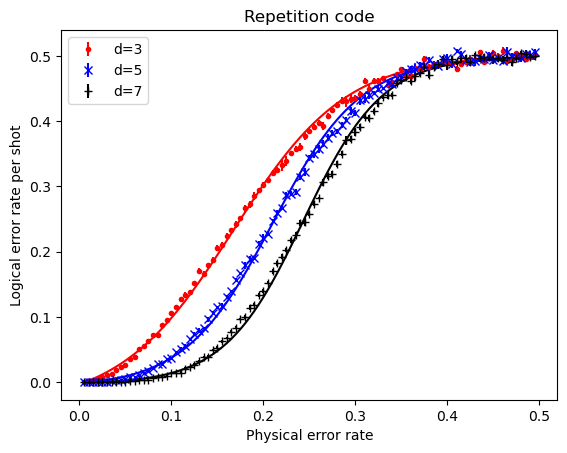

In [7]:
for i in range(num_d):
  runtime = -time.time()
  d = distance[i]
  c = colors[i]
  m = marker[i]
  dat = np.zeros(num_x)
  err = np.zeros(num_x)
  print("Doing d=%d" % d)
  for n in range(num_x):
    p = error_probs[n]
    for j in range(Nsamples):
      circuit = stim.Circuit.generated("repetition_code:memory",
                                       rounds=3 * d, distance=d,
                                       before_round_data_depolarization=p)

      Nerr = count_logical_errors(circuit, shots_per_sample)
      td = Nerr / shots_per_sample
      dat[n] += td
      err[n] += td * td

    # Compute mean and standard error
    dat[n] /= Nsamples
    err[n] /= Nsamples
    td = err[n] - dat[n] * dat[n]
    err[n] = np.sqrt(td / (Nsamples - 1.0))

    # err=0 breaks errfunc and distorts fit...
    # Rough experimentation with empirical fix...
    if err[n] == 0.0:
      err[n] = 1.0 / (Nsamples * shots_per_sample)

  # Extract and save fit parameters, using Levenberg--Marquardt algorithm
  all_out = least_squares(errfunc, p_in, jac=jac, method='lm',
                          args=(error_probs, dat, err))
#  all_out = least_squares(errfunc, p_in, method='dogbox',
#                          args=(error_probs, dat, err))

  p_out = all_out.x

  # Monitor final fit parameters
  print(p_out)

  # Smaller d seem happier (probably due to more dat=0 for larger d)
  # Try resetting p_in for larger d with that from smaller-d fit
  p_in = p_out

  # Compute chiSq and confidence level of fit
  chiSq = ((errfunc(p_out, error_probs, dat, err))**2).sum()
  dof = num_x - len(p_out)
  CL = 1.0 - gammainc(0.5 * dof, 0.5 * chiSq)
  print("chiSq/dof = %.4g/%d = %.4g --> CL = %.4g" \
        % (chiSq, dof, chiSq / dof, CL))

  # Plot both points and fit
  plt.errorbar(error_probs, dat, yerr=err, c=c, marker=m, \
               ls='none', label="d=" + str(d))
  curve = fitfunc(p_out, error_probs)
  plt.plot(error_probs, curve, c=c)

  # Monitor runtime for each d
  runtime += time.time()
  print("Runtime: %0.1f seconds\n" % runtime)

plt.title("Repetition code")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate per shot")
plt.legend()
plt.show()